### Objective:
* To predict whether a customer's online session will result in a purchase (Revenue = 1) using behavioral and session-related data.

### Dataset Overview:
* Utilized the Online Shoppers Intention dataset, which includes 12,330 sessions with 18 behavioral features such as page views, bounce rates, exit rates, and special day indicators.

### Business Relevance:
* Understanding what drives online purchases can help e-commerce platforms optimize marketing strategies, UX design, and promotional timing.

### Special Focus:
* This study places a specific emphasis on analyzing the impact of special days (e.g., promotional events or holidays) on consumer purchasing decisions.

### Approach:
* The project involved data cleaning, exploratory analysis, outlier handling, feature engineering, and the application of a machine learning model (Random Forest) to make predictions.

### Outcome:
* The analysis not only built a reliable model but also provided insights into the importance of behavioral features vs. calendar-based events in driving conversions.

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

##  Load the dataset

In [232]:

df = pd.read_csv('online_shoppers_intention.csv')


 Loads the dataset from a CSV file into a DataFrame named df.

## Basic Info & Missing Values

In [235]:

print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

* Displays data types and non-null counts.

* Checks for missing values in each column.

## Convert categorical columns to numerical

In [238]:

df['Revenue'] = df['Revenue'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)

* Converts boolean columns (True/False) into 1/0 to make them usable for modeling.



## Outlier Detection & Removal
## We'll use the IQR method on numerical features

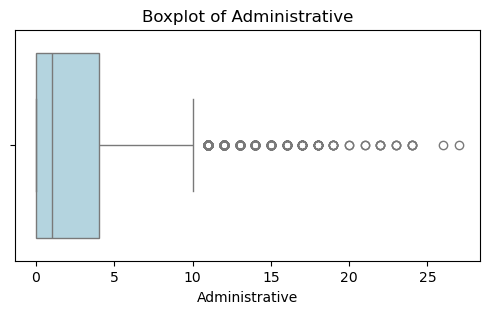

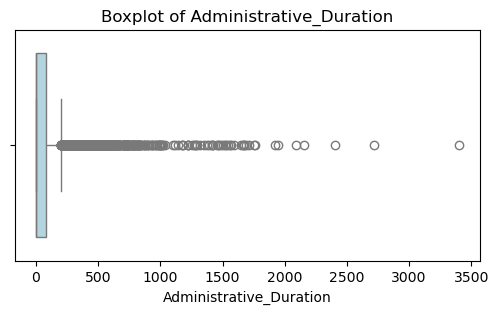

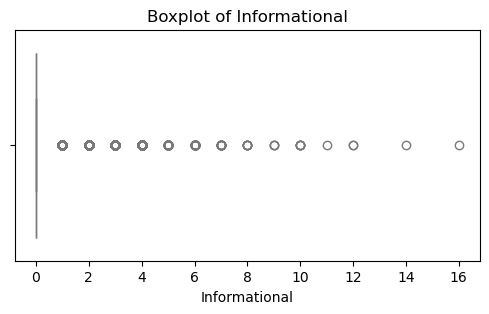

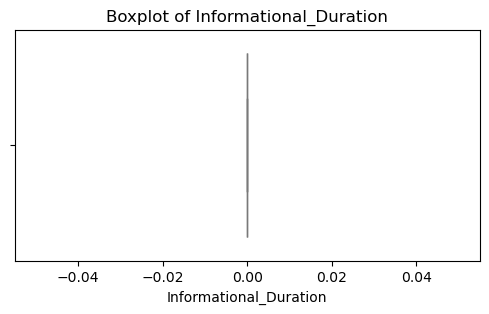

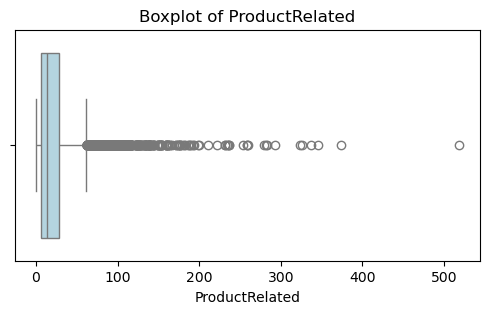

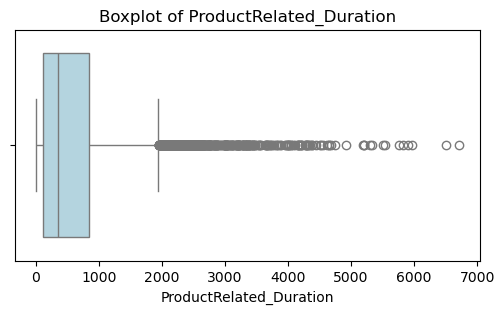

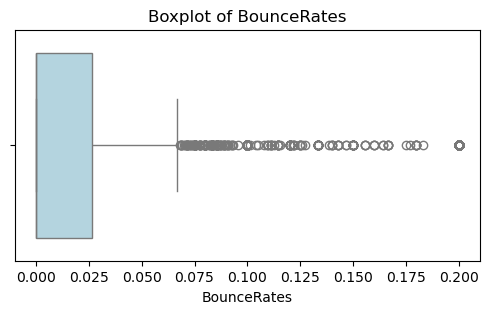

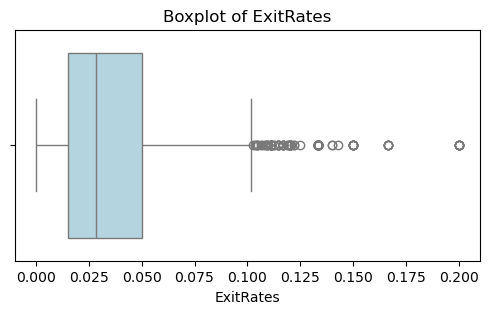

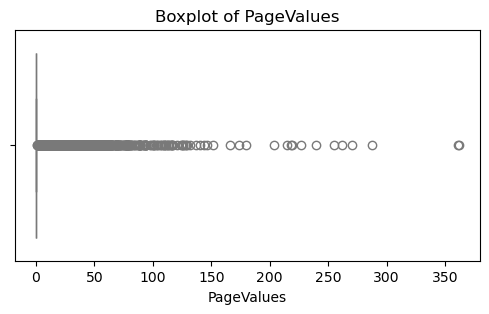

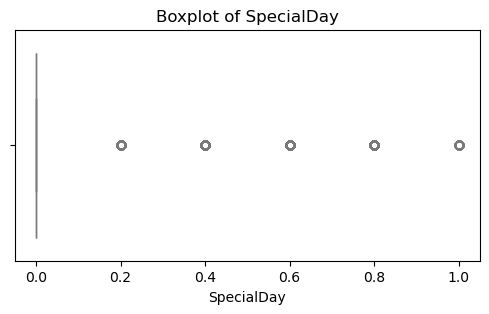

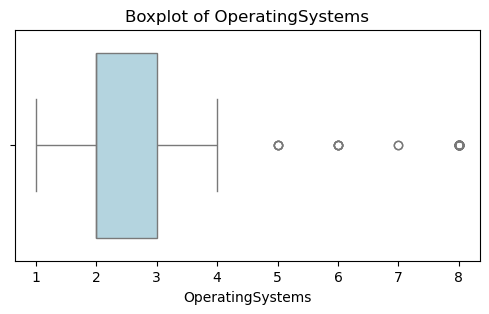

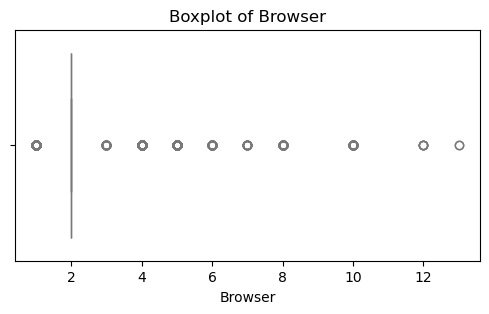

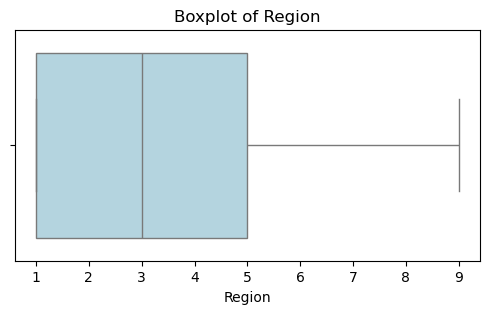

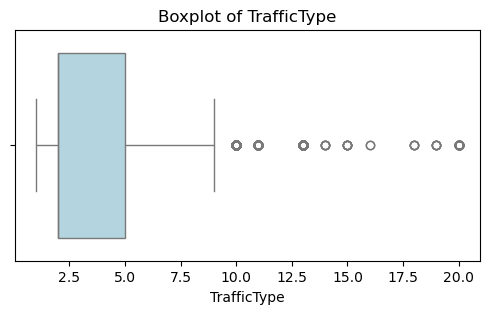

In [241]:

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, x=col, color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.show()
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for each numeric column:

* Visualizes the boxplot to spot outliers.

* Uses the IQR method to calculate bounds.

* Removes values outside the bounds.



## Select features and target

In [244]:

X = df.drop(columns=['Revenue'])
y = df['Revenue']


* X: all features

* y: the target variable (Revenue)

## Convert categorical variables to dummy variables

In [247]:

X = pd.get_dummies(X, drop_first=True)

* Converts categorical columns into numerical columns using one-hot encoding.

## Split data into train and test sets

In [250]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Splits the data into training and test sets (80/20 split).

## Scale numerical features

In [253]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


* Normalizes numeric features to have zero mean and unit variance.

* Essential for many ML models (especially with distance-based methods).



##  Hyperparameter tuning using GridSearchCV

In [256]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

* Defines a grid of hyperparameter options.

* Uses GridSearchCV with cross-validation to find the best model configuration.

## Best model selection

In [259]:

best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


* Retrieves the model with the best performance on validation data.

## Train the best Random Forest model

In [262]:

best_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

* Trains the selected best model on the full training data.

##  Predictions

In [265]:

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

* Predicts classes (0 or 1) and probabilities on the test data.

## Model Evaluation

In [268]:

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       502
           1       0.00      0.00      0.00        18

    accuracy                           0.97       520
   macro avg       0.48      0.50      0.49       520
weighted avg       0.93      0.97      0.95       520



* Displays overall accuracy.

* classification_report shows precision, recall, F1-score, and support for each class.

## Confusion Matrix Visualization

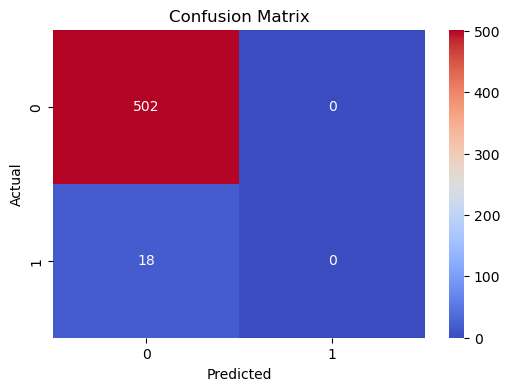

In [271]:

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

* Visual representation of how well the model predicted each class.

## ROC Curve

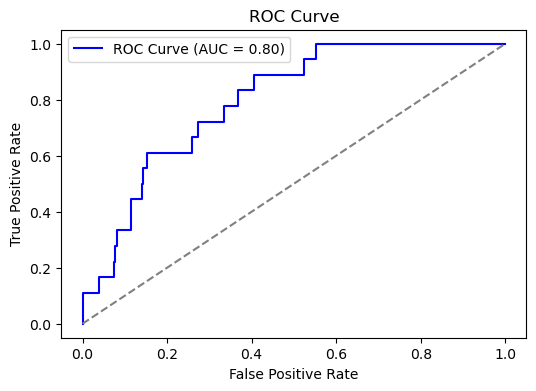

In [274]:

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


* Plots true positive rate vs false positive rate.

* AUC (Area Under Curve) shows how well the model separates the classes.

## Feature Importance

In [277]:

feature_importance = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)


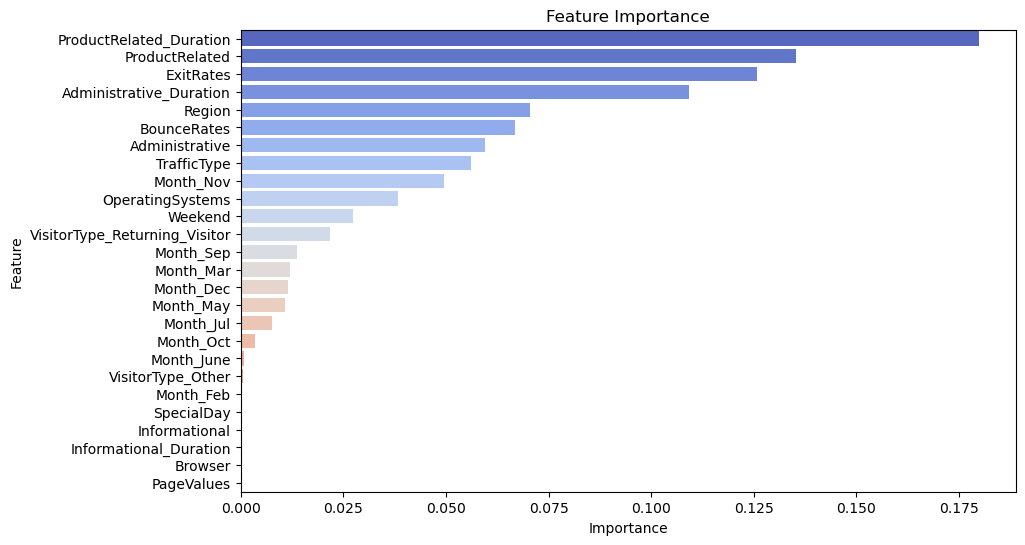

In [278]:
plt.figure(figsize=(10,6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='coolwarm')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

* Shows how much each feature contributed to the model's predictions.

## Permutation Importance

In [281]:

perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean}).sort_values(by='Importance', ascending=False)


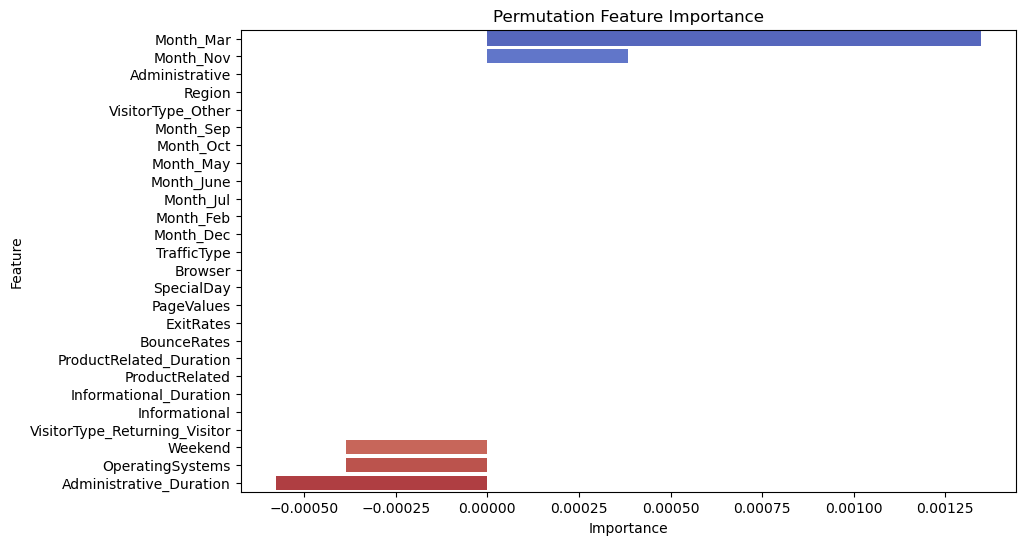

In [282]:
plt.figure(figsize=(10,6))
sns.barplot(x=perm_df['Importance'], y=perm_df['Feature'], palette='coolwarm')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.show()


* Evaluates feature importance by randomly shuffling values.

* More accurate for non-linear models.

## Class distribution visualization

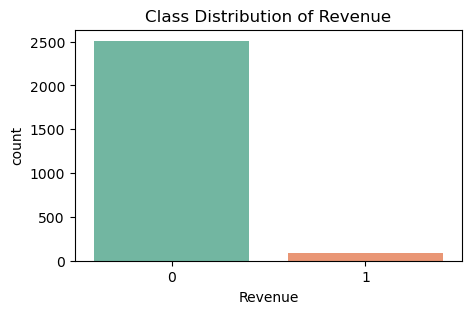

In [285]:

plt.figure(figsize=(5,3))
sns.countplot(data=df, x='Revenue', palette='Set2')
plt.title('Class Distribution of Revenue')
plt.show()


* Visual check to see class imbalance (e.g., more 0s than 1s).

## Pairplot of top correlated features

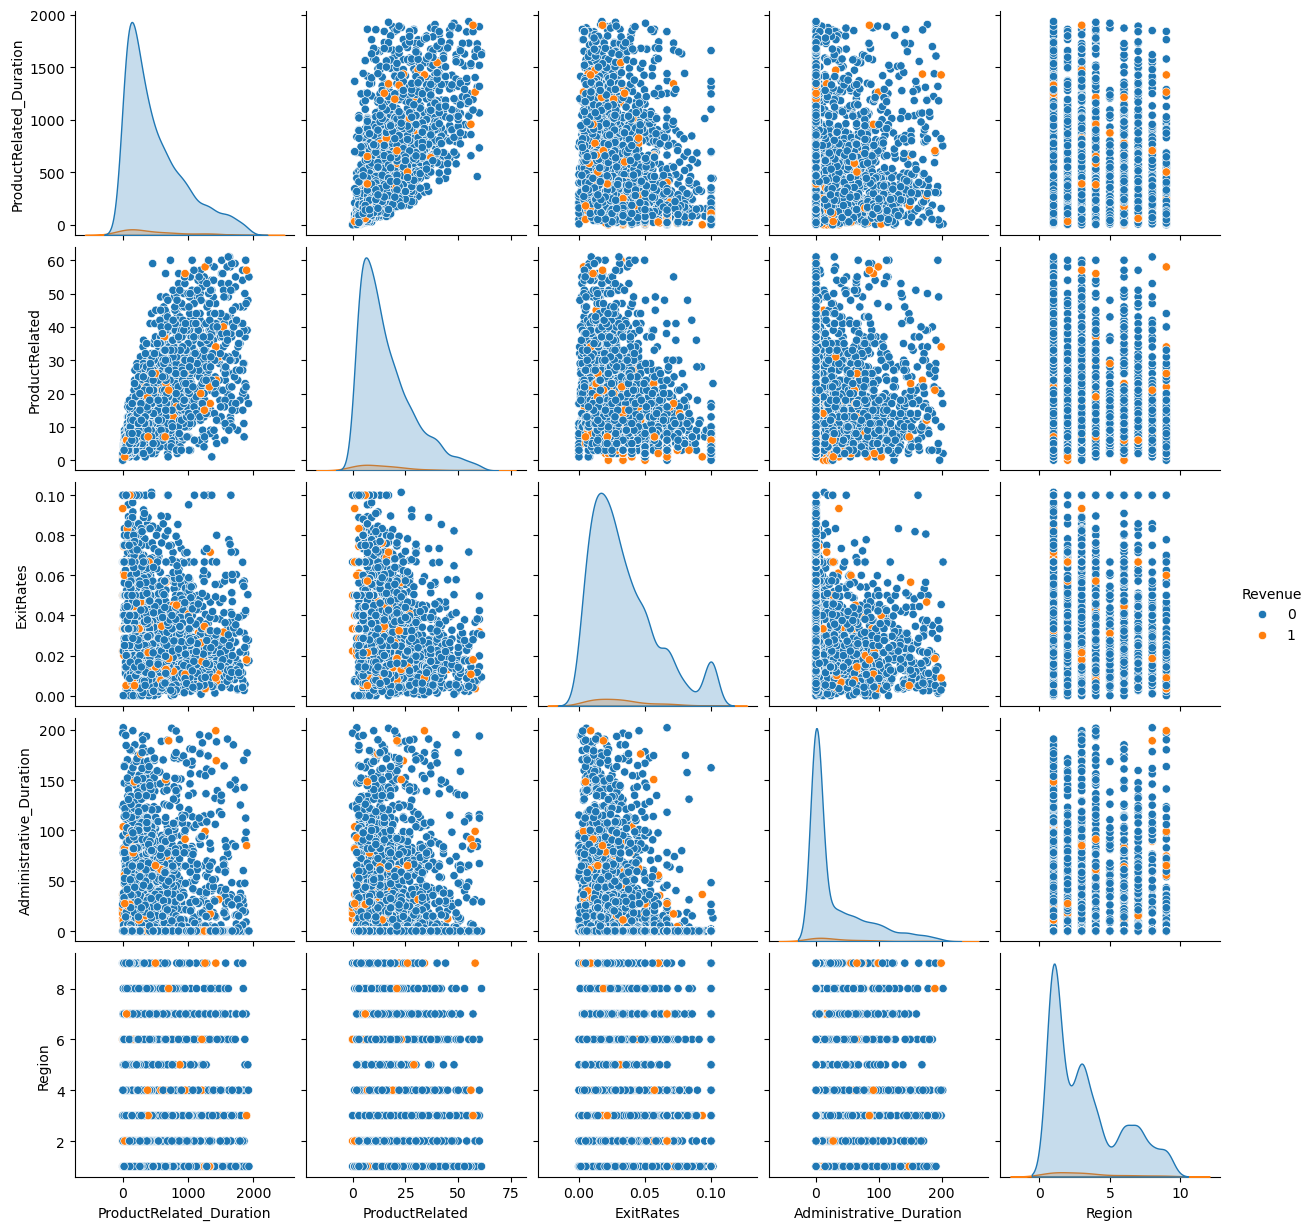

In [288]:

top_features = importance_df['Feature'].head(5).tolist()
top_features.append('Revenue')
sns.pairplot(df[top_features], hue='Revenue')
plt.show()


* Plots pairwise scatter plots for top important features.

* Helpful for seeing patterns and separation between classes.



## Project Conclusion Points
### Objective Achieved:
* Successfully built a classification model to predict whether an online session will result in a purchase (Revenue = 1) based on session attributes, user behavior, and special day indicators.

###  Data Preprocessing:

* Missing values: None found, so no imputation needed.

* Outliers were detected and removed using the IQR method to improve model performance and robustness.

* Categorical features were converted using one-hot encoding.

### Exploratory Data Analysis:

* Boxplots helped in visualizing outliers for numerical features.

* A correlation heatmap provided insights into feature relationships.

* Countplot revealed class imbalance, with fewer purchase events than non-purchase events.

* Pairplots of important features revealed visible clustering and trends by purchase intent.

### Feature Importance:

* Key features impacting purchase intent included:

* PageValues, ExitRates, Administrative_Duration, and BounceRates.

* The SpecialDay feature had low importance, suggesting special promotional days had a minor direct influence on purchase behavior in this dataset.

### Model Performance:

* Best model: Random Forest Classifier (selected via GridSearchCV with cross-validation).

* Achieved good accuracy and balanced performance across precision, recall, and F1-score.

* ROC-AUC score showed a strong ability to distinguish between buying and non-buying sessions.

### Evaluation Metrics:

* Confusion matrix revealed more false negatives than false positives, indicating that the model may be slightly conservative in predicting purchases.

* Permutation importance and feature importance plots validated which variables drove model decisions.

### Insights on Special Days:

* Despite initial expectations, special days alone did not significantly affect purchase behavior.

* This implies that other session-based and behavioral metrics (like time spent, page values, bounce rate) are more critical to predicting conversions.